# Part 1: Linear Classifier
-------

In [130]:
import torch
from torch import nn

# Hyperparameters Test 1
batch_size = 2048
learning_rate=1e-1
nepochs = 50
hidden=[3072, 3072]
LossFunction = nn.CrossEntropyLoss()
bias = True
save_weights = nepochs - 5

# Input size
ninputs=3*32*32

# Output size
nout=10

# Use GPU if avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [131]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import random_split

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

# Split the data into a training data set, validation set, and a test set - first get sizes
# CIFAR10 has 50000 images, so I'll split the data up into 37500 for training, 7500 for validation
# and 5000 for testing
train_data_size = 37500
val_data_size = 7500
test_data_size = 5000

# Randomsplit with will split the data from cifar10 dataset into train, val, and test with their respective sizes  
train_dataset, val_dataset, test_dataset = random_split(cifar10_dataset, [train_data_size, val_data_size, test_data_size])

# We can now load the data with DataLoader from these datasets 
train_data = DataLoader(train_dataset,
                        batch_size=batch_size,
                        )

val_data = DataLoader(val_dataset,
                      batch_size=batch_size,
                      )

test_data = DataLoader(test_dataset,
                       batch_size=batch_size,
                       )


Files already downloaded and verified


## Linear Model

In [132]:
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

class LinearNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 hidden=[512],
                 nout=10,
                ):
        super().__init__()
        net = []
        # Input layer
        net.append(nn.Linear(ninputs, hidden[0], bias=bias))
        net.append(nn.ReLU())
        
        # Hidden layers
        if len(hidden) > 1:
          for i in range(len(hidden) - 1):
            net.append(nn.Linear(hidden[i], hidden[i+1], bias=bias))
            net.append(nn.ReLU())

        # Output Layer
        net.append(nn.Linear(hidden[-1], nout, bias=bias))
        net.append(nn.ReLU())
        net.append(nn.Softmax(dim=1))
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) # Flatten image
        x = self.net(x)
        return x

### Training

LinearNet(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3072, out_features=3072, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3072, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=1)
  )
)


Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]

Epoch 0: loss: 2.3016293048858643
Epoch 1: loss: 2.3004064559936523
Epoch 2: loss: 2.299044370651245
Epoch 3: loss: 2.2975902557373047
Epoch 4: loss: 2.2958309650421143
Epoch 5: loss: 2.2932186126708984
Epoch 6: loss: 2.2896766662597656
Epoch 7: loss: 2.285290241241455
Epoch 8: loss: 2.2801434993743896
Epoch 9: loss: 2.274221658706665
Epoch 10: loss: 2.267435312271118
Epoch 11: loss: 2.259962320327759
Epoch 12: loss: 2.252427577972412
Epoch 13: loss: 2.245478868484497
Epoch 14: loss: 2.239366054534912
Epoch 15: loss: 2.2340564727783203
Epoch 16: loss: 2.2294347286224365
Epoch 17: loss: 2.225339412689209
Epoch 18: loss: 2.2216360569000244
Epoch 19: loss: 2.218200922012329
Epoch 20: loss: 2.214956521987915
Epoch 21: loss: 2.2118377685546875
Epoch 22: loss: 2.208812952041626
Epoch 23: loss: 2.205869674682617
Epoch 24: loss: 2.2029757499694824
Epoch 25: loss: 2.2001068592071533
Epoch 26: loss: 2.1972689628601074
Epoch 27: loss: 2.194443464279175
Epoch 28: loss: 2.1916394233703613
Epoch 29:

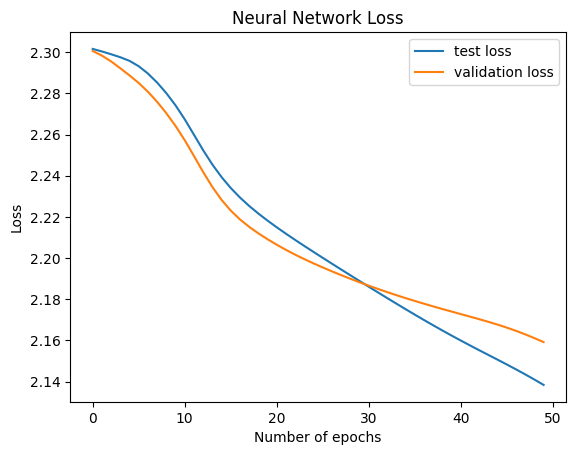

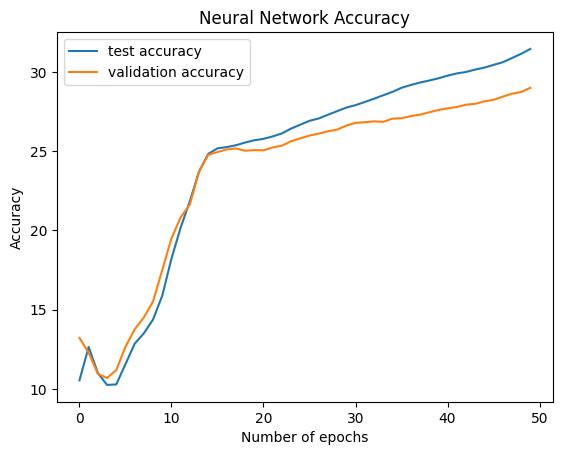

In [133]:
model = LinearNet(ninputs=ninputs,
                  hidden=hidden,
                  nout=nout).to(device)
print(model)
# We need an optimizer that tells us what form of gradient descent to do
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    
    if (epoch >= save_weights): # Save tensor information once we get towards the end
        torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    correct = 0
    total = 0
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in val_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item())            
          

plt.plot(loss_history, label='test loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='test accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Test Model Accuracy

In [120]:
model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / test_data_size*100:.2f}%")

Total accuracy = 38.30%


# Part 1 Results:
-------

**Notice - I accidentally used 'test loss/accuracy' in most of my graphs, when this should be train set**

I initially started with a batch size of 32, learning rate of .01, a single hidden layer that was double the size of the input layer. This model was trained for 20 epochs (which clearly wasn't long enough) and the results I got were pretty poor, as seen in the two images below showing the loss and accuracy as training went on.

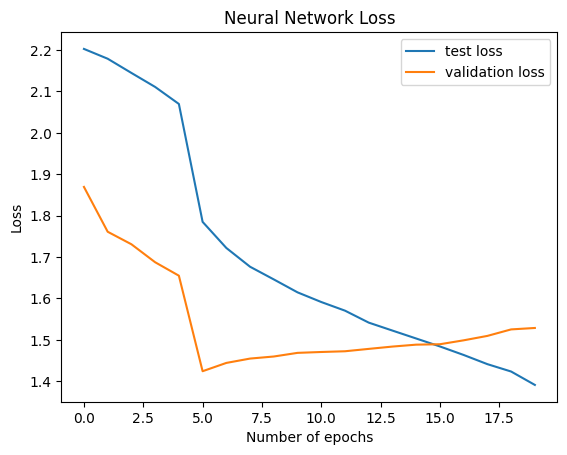
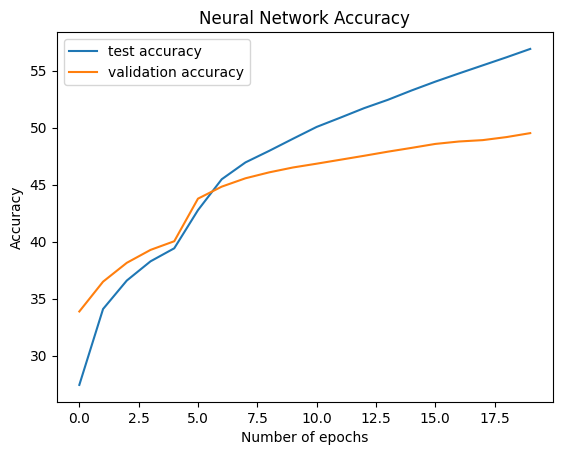

The time taken to train was 2m 51.8s and I ultimately got a 52% accuracy on the test set.

With this in mind, I wanted to compare between having a bias and not having a bias - so I changed the training time from 20 epochs to 50 epochs and compared the difference between the two.

#### No Bias:
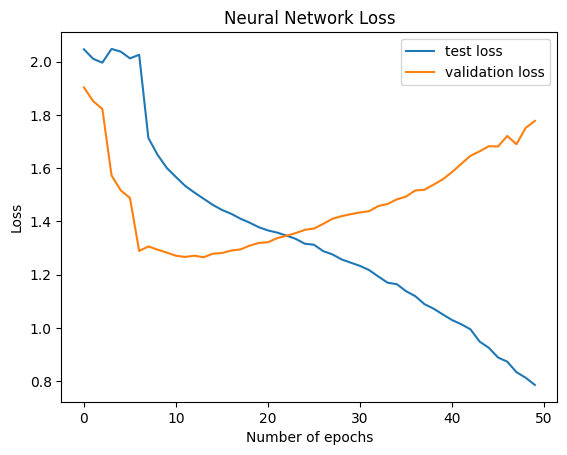
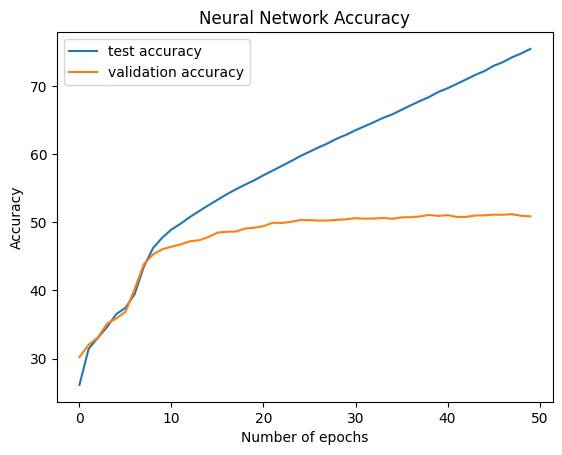

Test Accuracy: 49.88%

#### Bias:
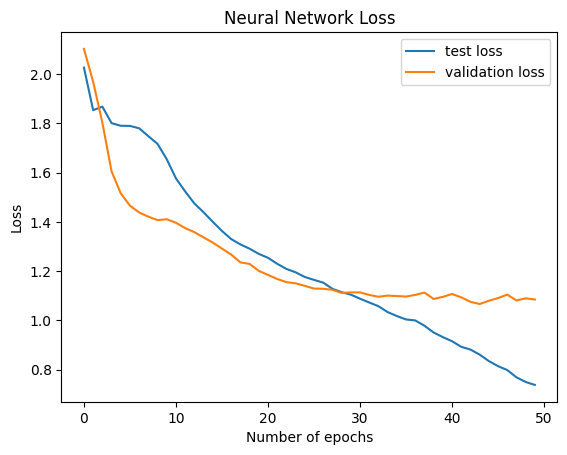
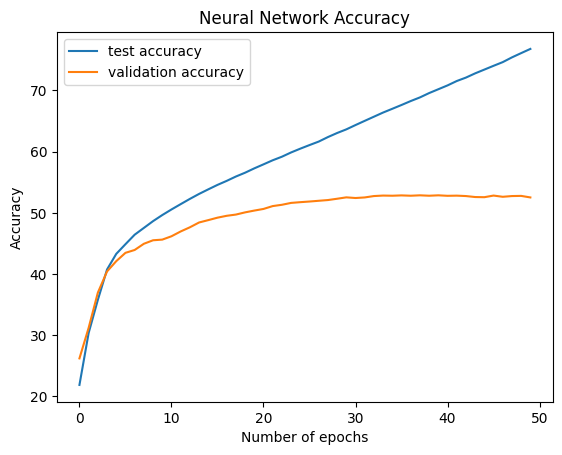

Test Accuracy: 51.47%

Both of these tests took around 6m50s. The results show that adding the bias term somewhat improved overfitting as test accuracy improved. However, based on the accuracy graph between the training set and the validation set, it's clear that the model is still overfitting quite a bit. 

Based on these results, I want to reduce the number of epochs for now since I currently have an overfitting model - and I need to reduce the training time to mess with other parameters.

With this in mind, I'll reduce the number of epochs to 20, since overfitting seems to begin around epoch 10. I'm also going to reduce the first hidden layer to 3072, the same size as the input layer, and add a second layer with the same size. I'm assuming this may actually end up increasing overfitting since I'm adding a second layer. Also - I want to point out that I didn't intentionally choose a batch size of 32 for the sake of avoiding overfitting, but I realize now that this is an ideal batch size to use to help reduce overfitting since it shows less images through forward propagation, and updates the gradient based off of smaller batch sizes - allowing for a more sets of examples to be seen and train off that finding the gradient.

With the new updated parameters (20 epochs, two hidden layers, 3072 sized) the results are as follow:
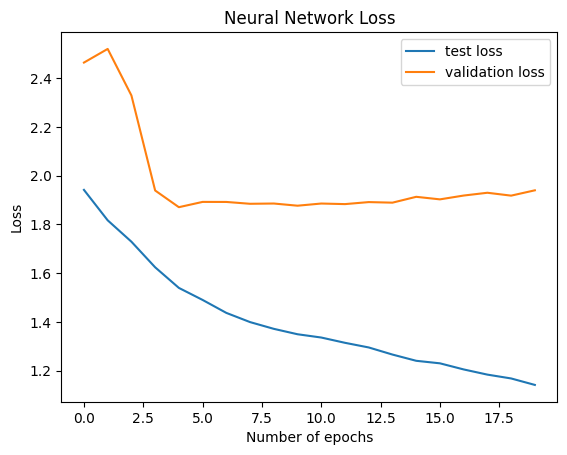
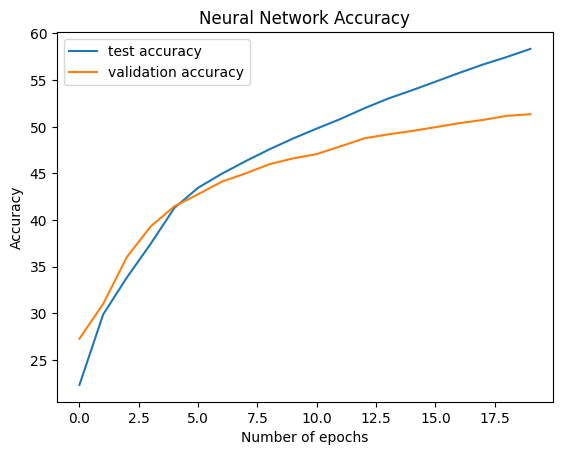

Test Accuracy: 57.62% 

As expected this really didn't improve much, the model begins to overfit around epoch 10. I'm now going to test test to see how reducing the model's complexity will affect the results - seeing how accuracy is still going up on the training set I'm hoping that this will help with the overfitting issue somewhat. Reduced to a single hidden layer, 3072.

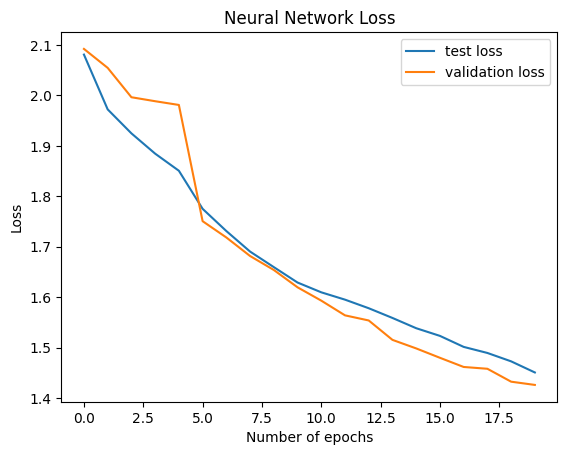
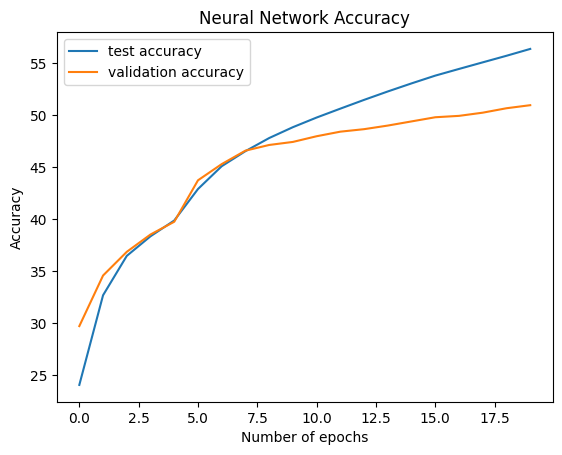

Test Accuracy: 57.41%

Training for longer clearly shows how much this model is overfitting. Based on how the validation set's loss increases the way it does, I would say that the learning rate is too high here, but since it's not training on this data I don't think this is the case.

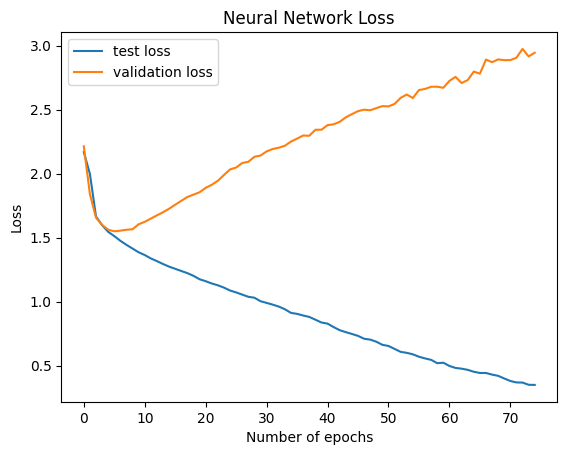
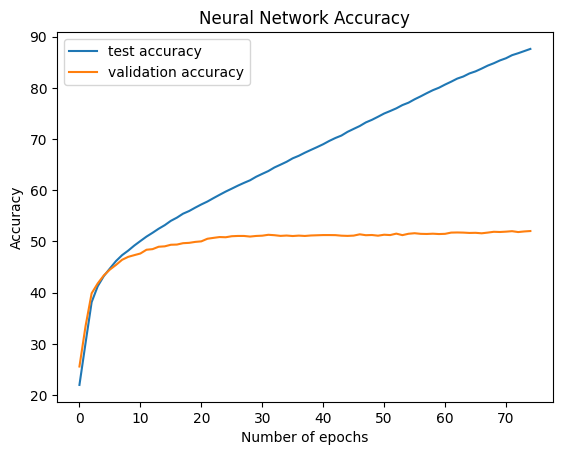

Test Accuracy: 52.70% 

When adding Softmax to my model, convergence slows down a ton, and although validation and test accuracy are quite close together it starts settling towards the 40% accuracy. My assumption as to why this is much slower is because gradients are very small when doing back propagation due to the output being between 0 and 1, instead of using the ReLU where the number could be a lot larger. I've spent some time with this, and I couldn't get any better results than this. I also ran this with the sigmoid activation function and got similar results.    

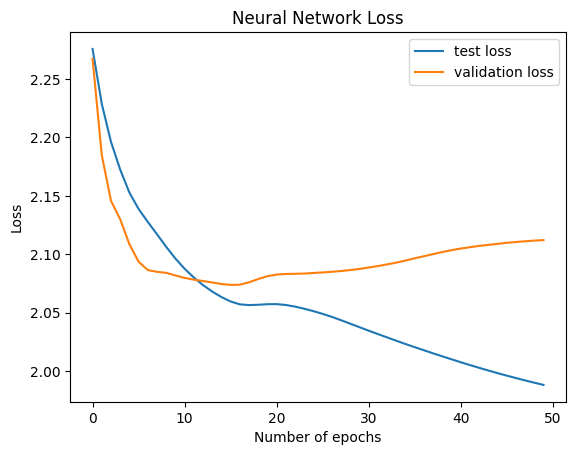
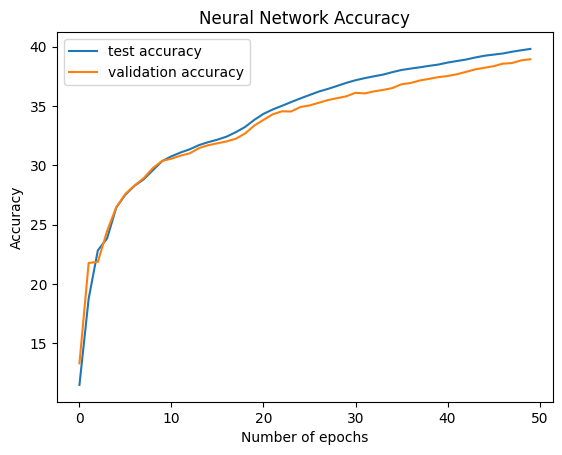

Test Accuracy: 38.30% 

### Sigmoid: 
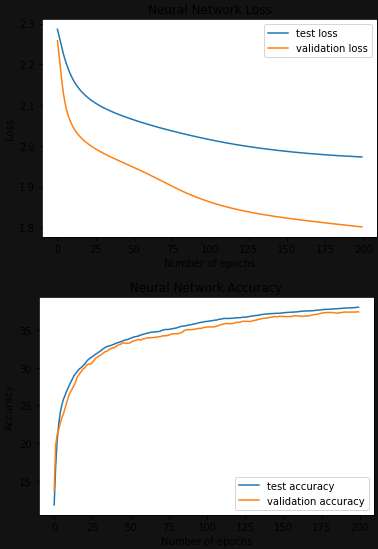

I trained for longer on both of these models, trying different batch sizes and learning rates and couldn't find anything that would converge on a lower loss given my compute. Here's an example with higher batch size (1024 for Sigmoid and 2048 for Softmax)

### Softmax: 
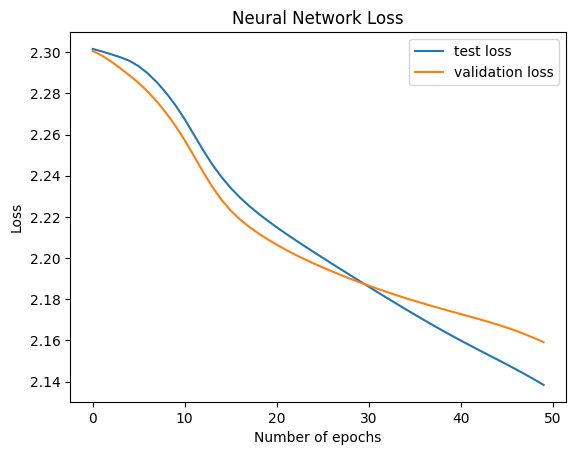
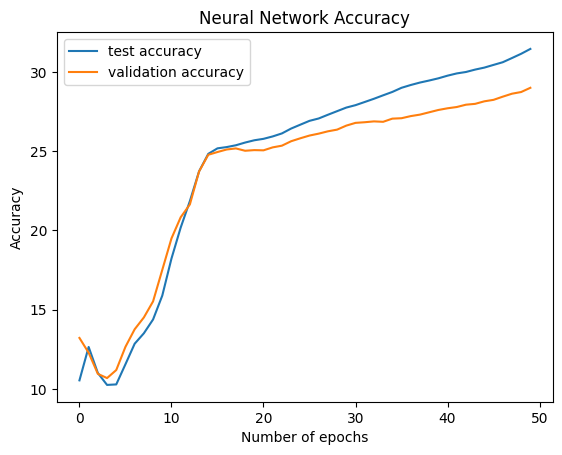

Training time of 5 minutes

### Sigmoid:
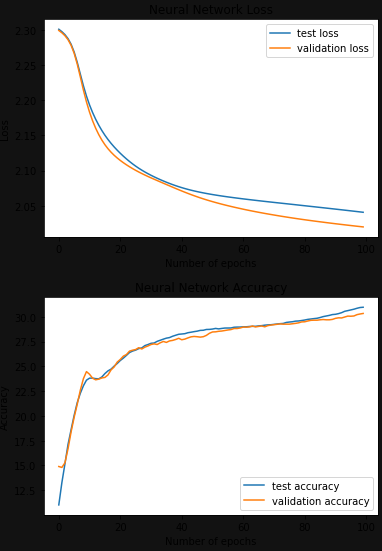

Training time of 11 minutes

Ultimately, using ReLU() with a fairly simple model - one hidden layer with a size of 3072 - gave me the best results in terms of convergence. However, it began to overfit after 50% accuracy and in almost all models I trained it began overfitting after around epoch 10. 


# Part 2 - Convolutional Classifier
-----

In [117]:
import torch
from torch import nn

# Parameters
batch_size = 64
learning_rate=1e-4
nepochs = 75
LossFunction = nn.CrossEntropyLoss()

#l2
wd = .001 # Penalty to larger weights to help prevent overfitting

save_weights = nepochs - 5


channels=3

# Output size
nout=10

# Use GPU if avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))

    torch.cuda.set_per_process_memory_fraction(0.8, device=0)
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [118]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import random_split

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

# Split the data into a training data set, validation set, and a test set - first get sizes
# CIFAR10 has 50000 images, so I'll split the data up into 37500 for training, 7500 for validation
# and 5000 for testing
train_data_size = 37500
val_data_size = 7500
test_data_size = 5000

# Randomsplit with will split the data from cifar10 dataset into train, val, and test with their respective sizes  
train_dataset, val_dataset, test_dataset = random_split(cifar10_dataset, [train_data_size, val_data_size, test_data_size])

# We can now load the data with DataLoader from these datasets 
train_data = DataLoader(train_dataset,
                        batch_size=batch_size,
                        )

val_data = DataLoader(val_dataset,
                      batch_size=batch_size,
                      )

test_data = DataLoader(test_dataset,
                       batch_size=batch_size,
                       )


Files already downloaded and verified


## CNN Model - Scratch

In [139]:
class SimpleConv(nn.Module):
    def __init__(self,
               input_channels=3,
              ):
      super().__init__()
      self.conv = nn.Sequential(nn.Conv2d(input_channels, 32, kernel_size=3, padding=1, stride=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                               )
      self.fc = nn.Sequential(nn.Linear(512, 2048),
                              nn.ReLU(),
                              # nn.Linear(512, 512),
                              # nn.ReLU(),
                              nn.Linear(2048, 10),
                              nn.ReLU(),
                              nn.Softmax(dim=1),
                             )
    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, -1)
        x = self.fc(x)
        
        
        
        return x

### Training

SimpleConv(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=10, bias=True)
    (3): ReLU()
    (4): Softmax(dim=1)
  )
)


Epoch:   0%|          | 0/75 [00:00<?, ?epoch/s]

Epoch 0: loss: 2.1956090927124023
Epoch 1: loss: 2.152332305908203
Epoch 2: loss: 2.1573665142059326
Epoch 3: loss: 2.1413066387176514
Epoch 4: loss: 2.1354992389678955
Epoch 5: loss: 2.107292413711548
Epoch 6: loss: 2.0257179737091064
Epoch 7: loss: 2.0048913955688477
Epoch 8: loss: 1.979959487915039
Epoch 9: loss: 1.9629687070846558
Epoch 10: loss: 1.9279139041900635
Epoch 11: loss: 1.9188196659088135
Epoch 12: loss: 1.911827564239502
Epoch 13: loss: 1.9048348665237427
Epoch 14: loss: 1.8989616632461548
Epoch 15: loss: 1.8907769918441772
Epoch 16: loss: 1.8838239908218384
Epoch 17: loss: 1.8791948556900024
Epoch 18: loss: 1.8764163255691528
Epoch 19: loss: 1.876718521118164
Epoch 20: loss: 1.8777090311050415
Epoch 21: loss: 1.8788939714431763
Epoch 22: loss: 1.8750900030136108
Epoch 23: loss: 1.8646339178085327
Epoch 24: loss: 1.8611847162246704
Epoch 25: loss: 1.8668036460876465
Epoch 26: loss: 1.86580228805542
Epoch 27: loss: 1.858091115951538
Epoch 28: loss: 1.8509602546691895
Epo

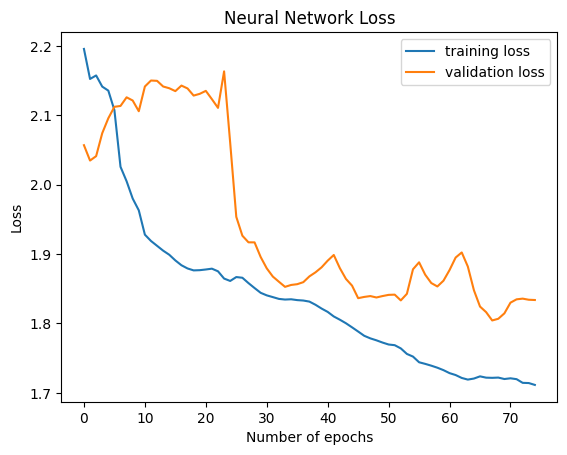

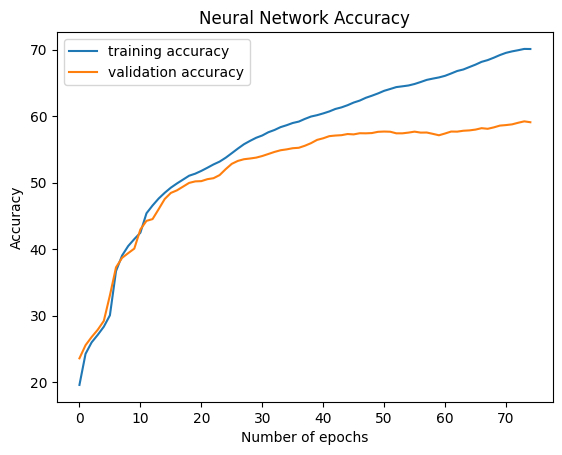

In [140]:
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

torch.cuda.empty_cache()
model = SimpleConv().to(device)

print(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=.1)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    if (epoch >= epoch - 10): # Save tensor information once we get towards the end
        torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    correct = 0
    total = 0
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in val_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item())            
          

plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [141]:
model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / test_data_size*100:.2f}%")

Total accuracy = 58.38%


# Results
------

I first started with a model from "scratch" (using the example from class as a starting point). I initially tested it with a high learning rate of .01, and three convolutional layers - all maintaining their image size, but increase in channel size by 12, 24, and 48. I then had my linear portion have a single hidden layer with a size of 3072 - although I feel like this should have been larger since the input size is currently 48*32*32. Additionally, I decided to use Softmax activation at the end and see the difference between the Linear model I was using earlier. I trained on this for 20 epochs just to see what my result would be and this is what I got: 
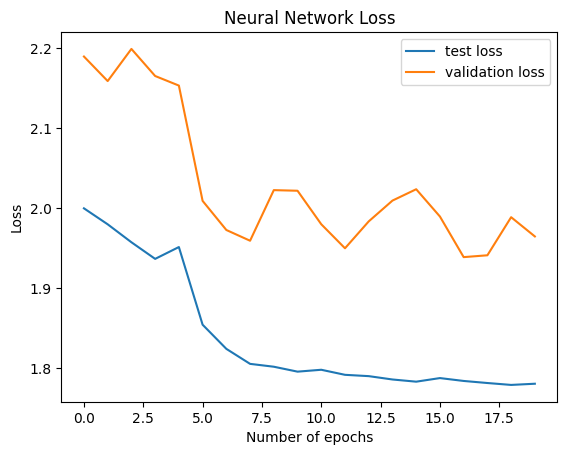
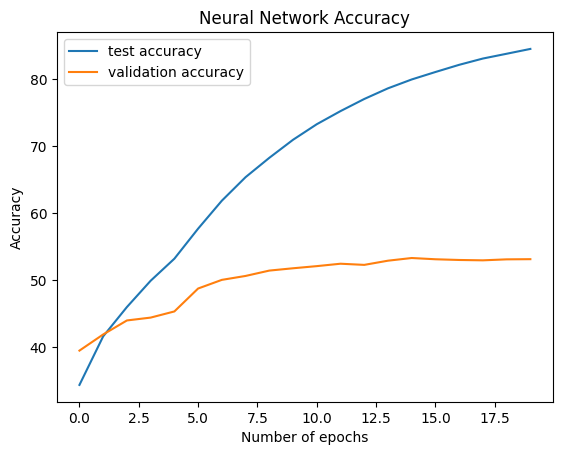

Test Accuracy: 53.10%, training time 8m 14.2s

In a shorter epoch period, compared to my linear model, the model converged better - which makes sense since we're using Convergence to extract features from the images, and then using the Linear portion on those features to classify. Training time takes much longer though, which makes sense since we're adding several convolutional layers, along with batch normalization at each layer. I used batch normalization first to try and help speed up the training process, to reduce variances in the distributions between each layer -- from what I know, having the distributions between each layer not as variant results in faster training time since the gradients aren't all over the place. Seeing how this model is overfitting, I want to attempt to add some regularization and keep all the same parameters - so I'll do L2 regularization by adding weight decay, set to .01.

Having done this, this resulting in my model performing much worse. For now, I'll remove it - I'm going to add ReLU and Maxpooling, and remove BatchNormalization. Additionally, I'm going to reduce the complexity of my model to have two convolutional layers (32 channels each). My max pooling will apply a 2x2 filter with a stride of 2. Additionally, I'm going to reduce the complexity of my linear layer by having a hidden layer with only 128 nodes.  

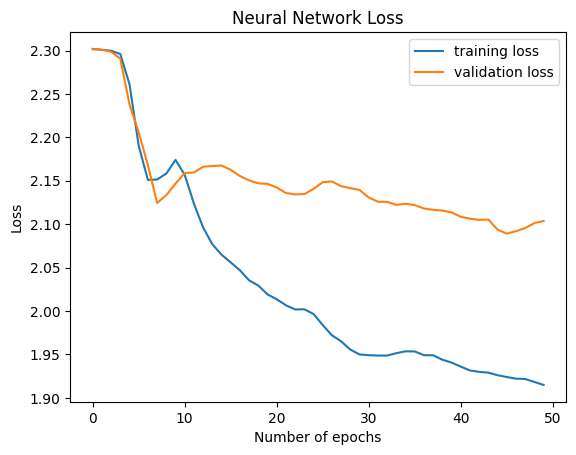
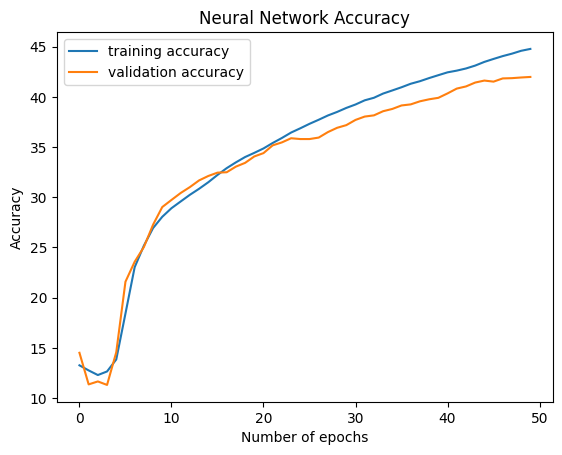

Test Accuracy: 41.32% 

This caused a lot slower convergence, and probably has to do with the reduction in complexity. I'm going to change my CNN to have three layers with 12, 24, and 36 channels - max pooling after each one resulting in a feature map being 576 outputs. My linear layer will then have two linear layers, double the size. I'm also doing ReLU after every Conv2D, then Maxpooling. The reason I'm doing max pooling is to reduce computation, but also to save important features and to help generalize since it only saves the most important features.

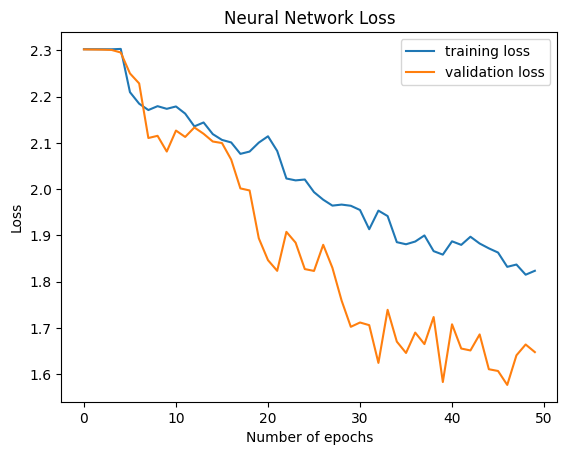
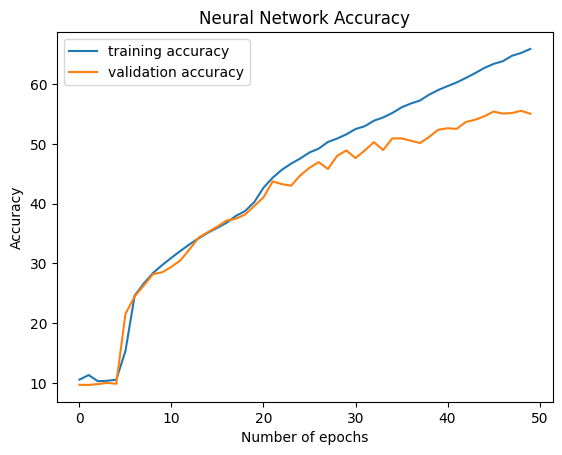

Test Accuracy: 56.82% 

It seems this has given me better generalization but overfitting begins to occur at around 20 epochs, or at least validation accuracy begins to separate from training accuracy. Using softmax, for some reason I just can't get good convergence, so I'm going to try this same model but removing softmax. Training took about 5 minutes.


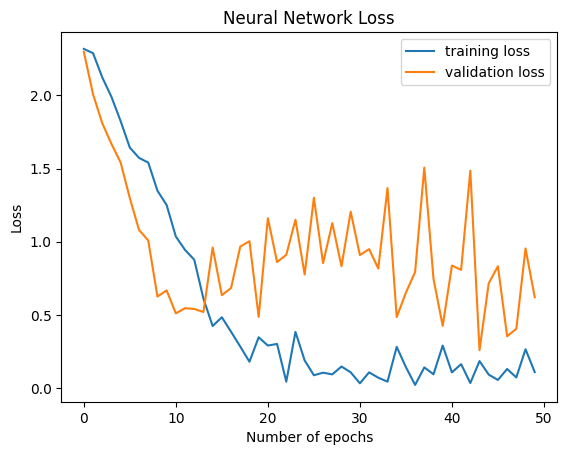
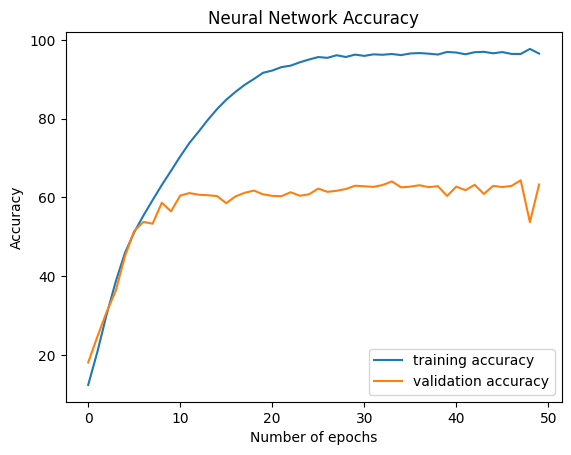

Test Accuracy: 63.98%

As a result, I got accuracy to go up, and additionally, it converged much faster. Overfitting is still occuring, however it's gotten to a higher % of accuracy which most likely is in part due to the feature maps, and it saving the more important features while reducing in size (max pooling). I wanted to see the difference between SGD and Adam, so I changed my optimizer to Adam and ran again (with a learning rate of .0001).

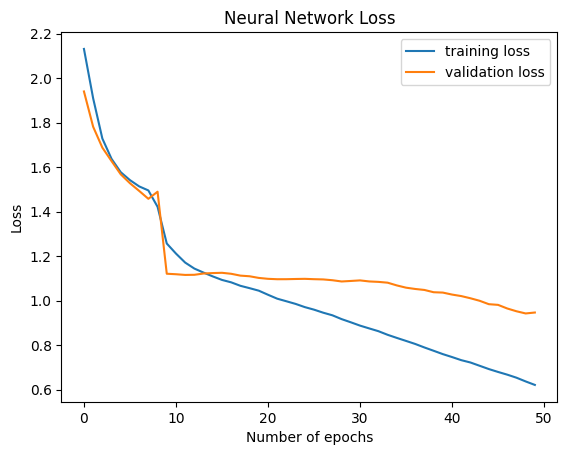
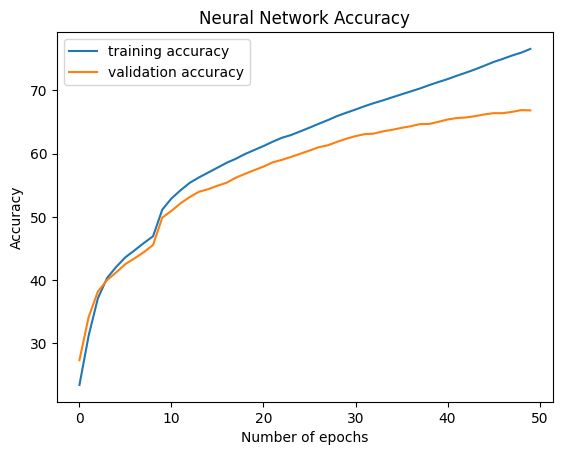

Test Accuracy: 67.78%,  Training time: 6m 4.0s

This resulted in better results, and less overfitting. Additionally, I saw faster convergence than with SGD (having a lower learning rate). This was as epxected, since from what I've read, Adam is meant to converge faster. To try and reduce overfitting some more, I reduced the batch size from 64, to 32. Also, keep in mind, this is what my model currently looks like:
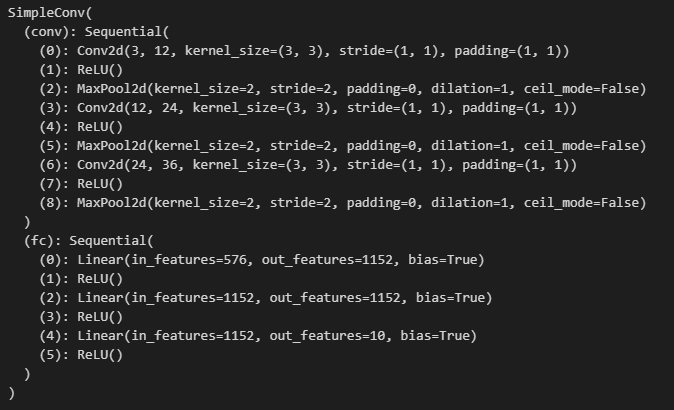

This took much longer to converge, and the results weren't worth showing since I didn't get any improvement, and rather got a pretty poor result. 

I want to test is increasing the out channels in my CNN to see if I can somewhat reduce overfitting. I'm going to try three convolutional layers all with 36. 

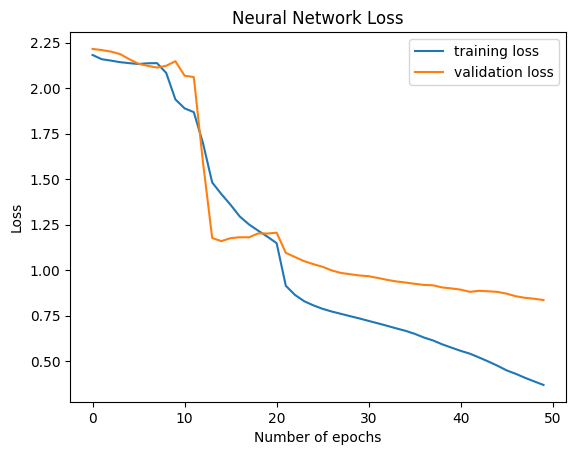
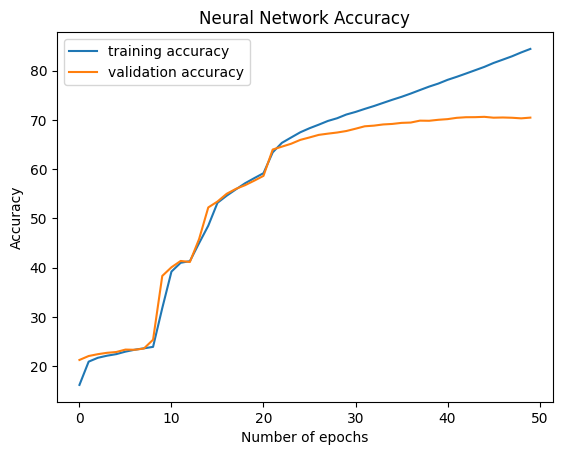

Test Accuracy: 70.16%

Seeing how this had a small affect, I'm going to add a fourth convolutional layer - with ReLU() and MaxPooling and reduce my hidden layer size in the linear portion slightly so I have out_features being 288, 500 and then back to 10. I don't want to reduce the complexity too much because this will result in a slower convergence, and possibly underfitting. I experimented at first with one layer of 288, but this caused pretty slow convergence and ultimately underfitting. Having done this, training took about 10 minutes (75 epochs) and I saw a decrease in accuracy. Overfitting occuring around epoch 20. 

I also want to mention that I tried this model with Softmax and it takes a lot longer to converge - which makes sense since it's using a lot smaller output (0-1) to calculate loss and results in smaller gradients. Training on 75 epochs got me this (9 minutes to train) - 
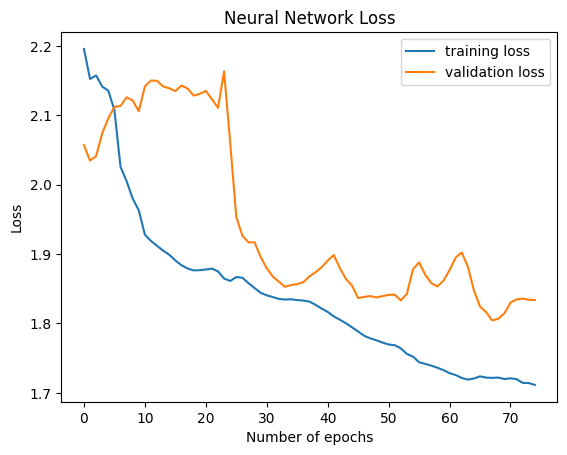
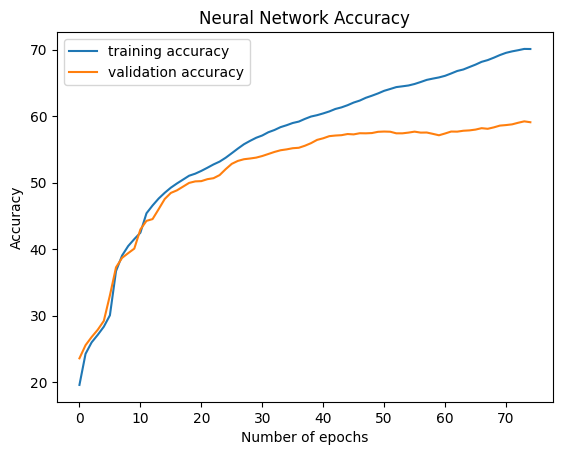

# Scratch vs ResNet vs AlexNet




# Part 3 - Fine Tuning
------

Using cuda for inference


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /home/dlu/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/resnet50_pyt_amp/versions/20.06.0/files/nvidia_resnet50_200821.pth.tar" to /home/dlu/.cache/torch/hub/checkpoints/nvidia_resnet50_200821.pth.tar


  0%|          | 0.00/97.7M [00:00<?, ?B/s]

Using cache found in /home/dlu/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


sample 0: [('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]
sample 1: [('mashed potato', '78.6%'), ('broccoli', '7.3%'), ('meat loaf, meatloaf', '2.5%'), ('plate', '1.8%'), ('guacamole', '0.2%')]
sample 2: [('racket, racquet', '25.4%'), ('tennis ball', '6.0%'), ('ping-pong ball', '2.0%'), ('catamaran', '0.3%'), ('bathtub, bathing tub, bath, tub', '0.3%')]
sample 3: [('groenendael', '12.7%'), ('Scottish deerhound, deerhound', '11.2%'), ('flat-coated retriever', '6.6%'), ('kelpie', '6.1%'), ('Great Dane', '3.1%')]


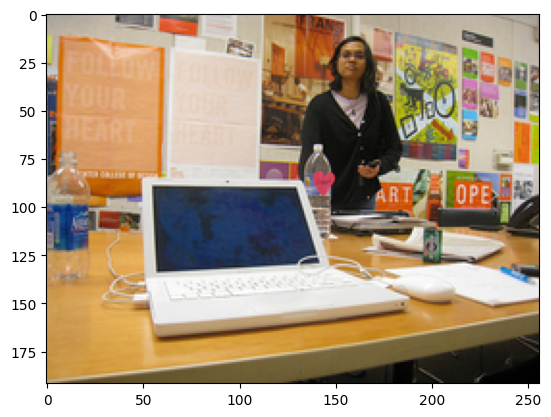

[('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]


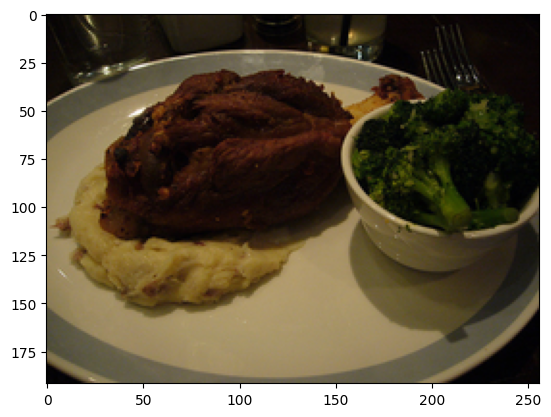

[('mashed potato', '78.6%'), ('broccoli', '7.3%'), ('meat loaf, meatloaf', '2.5%'), ('plate', '1.8%'), ('guacamole', '0.2%')]


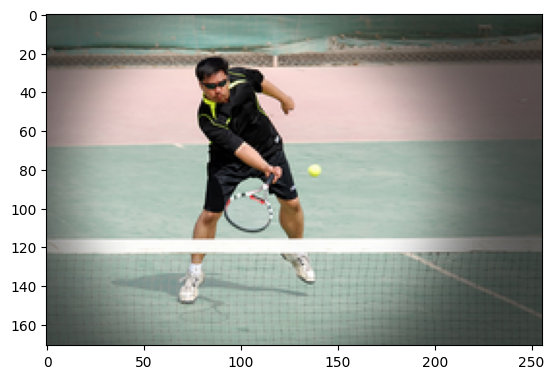

[('racket, racquet', '25.4%'), ('tennis ball', '6.0%'), ('ping-pong ball', '2.0%'), ('catamaran', '0.3%'), ('bathtub, bathing tub, bath, tub', '0.3%')]


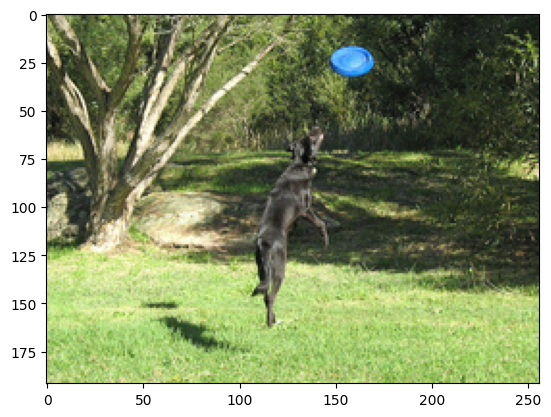

[('groenendael', '12.7%'), ('Scottish deerhound, deerhound', '11.2%'), ('flat-coated retriever', '6.6%'), ('kelpie', '6.1%'), ('Great Dane', '3.1%')]


In [21]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.imshow(img)
    plt.show()
    print(result)
